# Curso de Visão Computacional
- Autor: Mateus Grellert (INF/UFRGS)
- Contato: mateus.grellert@inf.ufrgs.br



# Detecção de Bordas e de Saliência
- Uma borda é uma região da imagem que normalmente representa o início ou o fim de um objeto.
- Se considerarmos uma imagem no domínio do pixel, uma borda acontece quando temos que temos uma variação elevada nos valores de pixels vizinhos.
- A intensidade e a direção desta variação pode ser obtida através da análise do gradiante (operador $\nabla$) desta imagem.
- A obtenção da intensidade do gradiante é obtida através de filtros de **convolução**.
<center> <img src = https://miro.medium.com/v2/resize:fit:1052/0*jLoqqFsO-52KHTn9.gif width=350 /> </center>

- Vamos explorar estes conceitos e alguns métodos clássicos de detecção de bordas abaixo. Vamos utilizar principalmente as bibliotecas **skimage** e **OpenCV**.

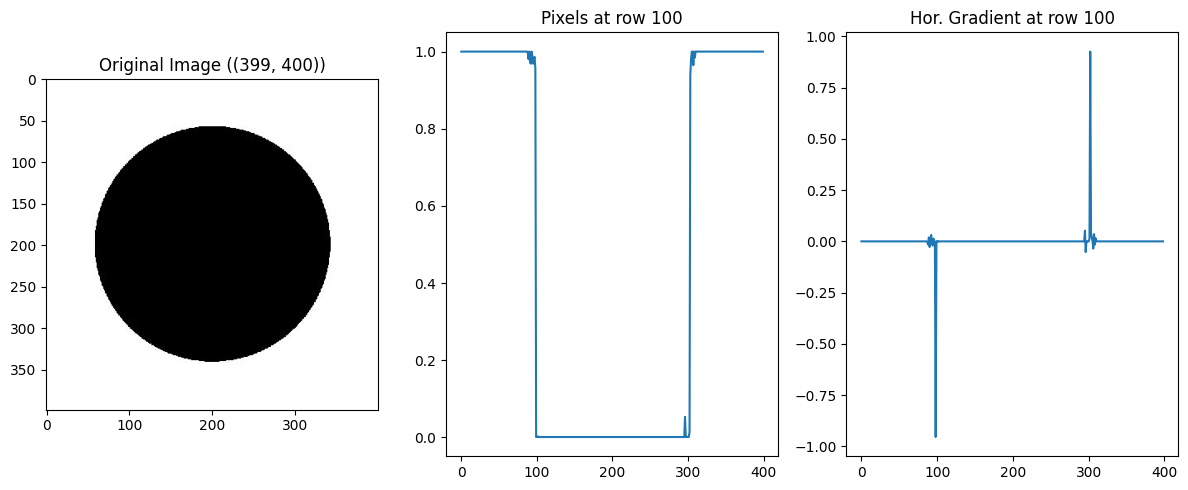

In [ ]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt

#img = skimage.data.coffee()
# opening the black_circle image for border visualization
img = skimage.io.imread('black_circle.jpg')

img_gray = skimage.color.rgb2gray(img)

plt.figure(figsize = (12,5))
plt.subplot(1,3,1)
plt.title(f'Original Image ({img_gray.shape})')
plt.imshow(img_gray, cmap = 'gray')

plt.subplot(1,3,2)
row_idx = 100
plt.plot(img_gray[row_idx, :])
plt.title(f'Pixels at row {row_idx}')

plt.subplot(1,3,3)
plt.plot(img_gray[row_idx, 1:] - img_gray[row_idx, :-1] )
plt.title(f'Hor. Gradient at row {row_idx}')

plt.tight_layout()
plt.show()


## Métodos clássicos
- Vamos agora aplicar a operação de convolução para aplicar o detector de Roberts, que usa kernels 2D. Para isso, vamos utilizar o método **scipy.signal.convolve**.
- Como a convolução pode gerar saídas com tamanho menor do que a entrada, podemos aplicar **padding** automaticamente com esse método através do parâmetro **mode=** *\"same\"*.

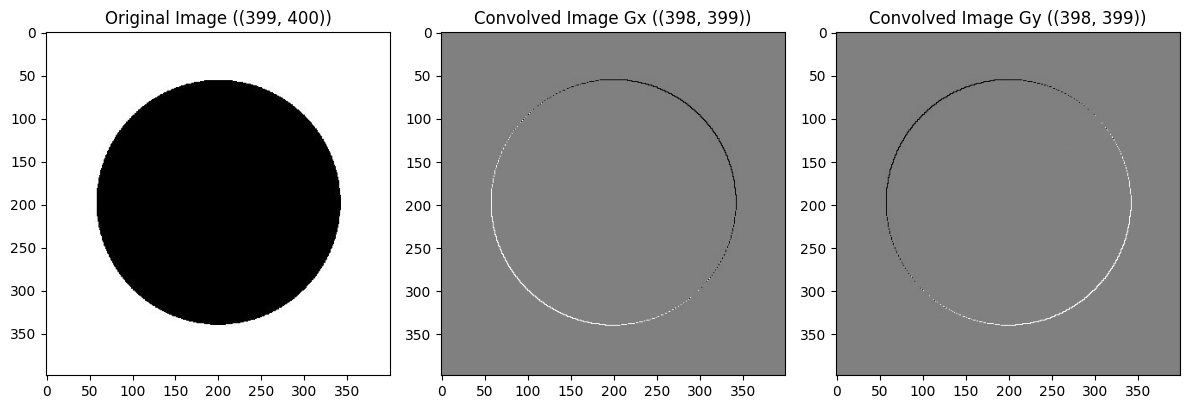

In [ ]:
import scipy.ndimage
import scipy.signal

# perform 2D convolution using Robert kernels
rob_gx = np.array([[ 0,1],
                   [-1,0]])

rob_gy = np.array([[ 1,0],
                   [0,-1]])

#convolved_image = scipy.ndimage.convolve(astronaut_gray, kernel, mode = 'constant', cval = 0)
img_grad_x = scipy.signal.convolve(img_gray, rob_gx, mode = 'valid').astype(np.float64)
img_grad_y = scipy.signal.convolve(img_gray, rob_gy, mode = 'valid').astype(np.float64)

# plot results
plt.figure(figsize = (12,5))
plt.subplot(1,3,1)
plt.title(f'Original Image ({img_gray.shape})')
plt.imshow(img_gray, cmap = 'gray')
plt.subplot(1,3,2)
plt.title(f'Convolved Image Gx ({img_grad_x.shape})')
ax = plt.imshow(img_grad_x, cmap = 'gray')
plt.subplot(1,3,3)
plt.title(f'Convolved Image Gy ({img_grad_y.shape})')
ax = plt.imshow(img_grad_y, cmap = 'gray')

plt.tight_layout()
plt.show()

- Vamos também calcular a magnitude dos gradiantes considerando a intensidade nas direções horizontais e verticais. A imagem do lado direito representa o histograma dos valores calculados.

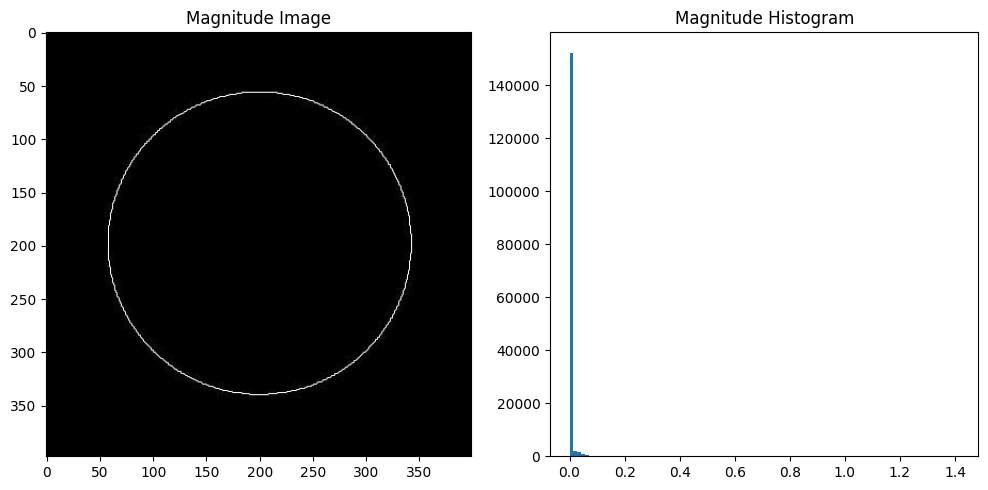

In [ ]:

plt.figure(figsize = (10,5))

plt.subplot(1,2,1)

mag_img = np.sqrt(img_grad_x**2 + img_grad_y**2).astype(np.float64)
plt.imshow(mag_img, cmap = 'gray')
plt.title('Magnitude Image')

plt.subplot(1,2,2)
plt.hist(mag_img.ravel(), bins = 100)
plt.title('Magnitude Histogram')

plt.tight_layout()

plt.show()

- Com a informação das magnitudes, podemos criar uma versão simplificada (quantizada) da imagem. A forma mais quantizada de todas é a **binarização**, que transforma todos os pixels abaixo de um certo limiar (*threshold*) em $0$, e todos acima em $1$.
- Determinar o valor de threshold pode ser feito através de medidas de média e dispersão, mas existe um método bastante eficiente chamado **método de Otsu**, que descobre o melhor threshold de forma a minimizar a variância interna das partes 0 e 1 da imagem.

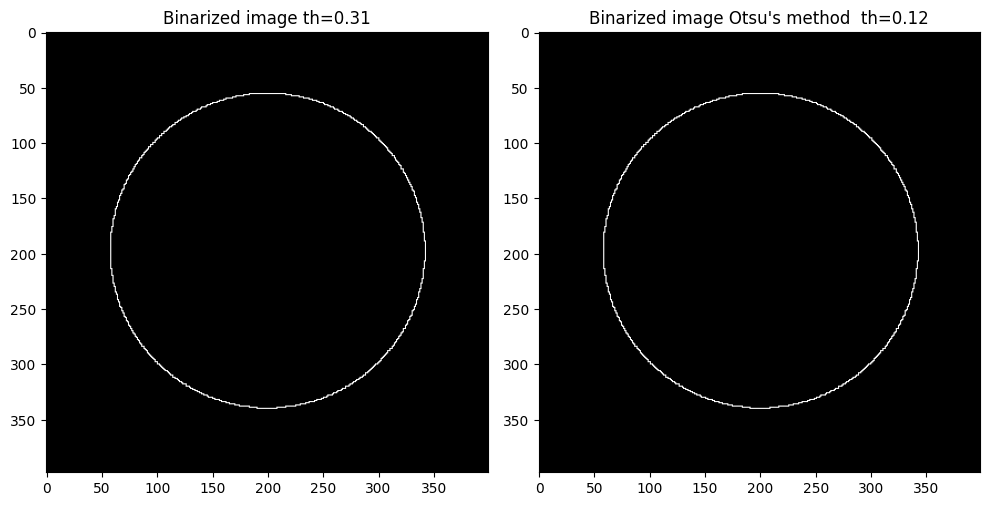

In [ ]:
from skimage.filters import threshold_otsu

plt.figure(figsize = (10,5))

th = mag_img.mean() + 3*mag_img.std()

mag_img_bin = mag_img.copy()
mag_img_bin[mag_img_bin < th] = 0
mag_img_bin[mag_img_bin > th] = 1

# binarzation using Otsu's method
th_otsu = threshold_otsu(mag_img)
mag_img_bin_otsu = mag_img_bin > th_otsu

plt.subplot(1,2,1)
plt.imshow(mag_img_bin, cmap = 'gray')
plt.title(f'Binarized image th={th:.2f}')

plt.subplot(1,2,2)
plt.imshow(mag_img_bin_otsu, cmap = 'gray')
plt.title(f'Binarized image Otsu\'s method  th={th_otsu:.2f}')

plt.tight_layout()

plt.show()



- Alguns métodos também se baseiam na direção do gradiente. Para visualizar as direções, podemos usar o método **pyplot.quiver**, como pode ser visto no código abaixo.

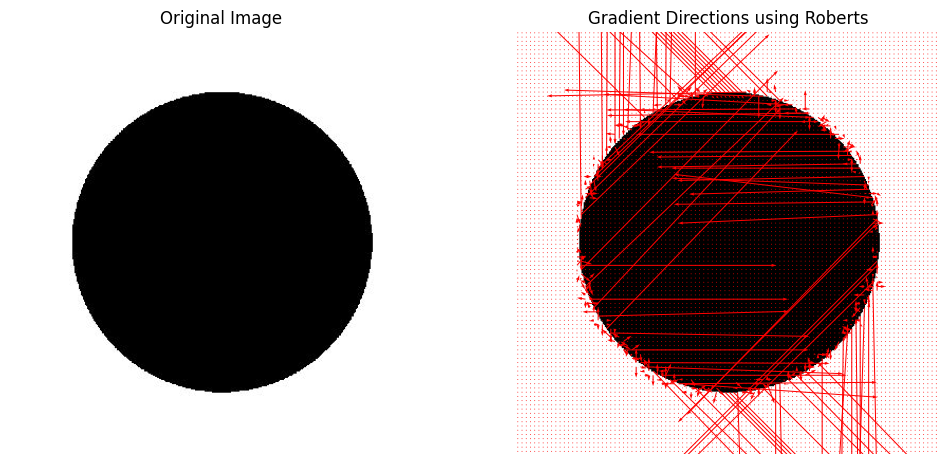

In [ ]:
import cv2
# Create a grid of coordinates
step = 4
x = np.arange(0, img_gray.shape[1], step)
y = np.arange(0, img_gray.shape[0], step)
X, Y = np.meshgrid(x, y)


# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Gradient Directions using Roberts')
plt.imshow(img_gray, cmap='gray')
plt.quiver(X, Y, img_grad_x[::step,::step], img_grad_y[::step,::step], color='red', angles='xy', scale_units='xy')
plt.axis('off')

plt.show()


- O filtro de Roberts tem como limitação sensibilidade ao ruído. Uma alternativa é o **filtro de Sobel**, que possui baixo custo computacional e é menos sensível ao ruído devido ao uso de kernels maiores.

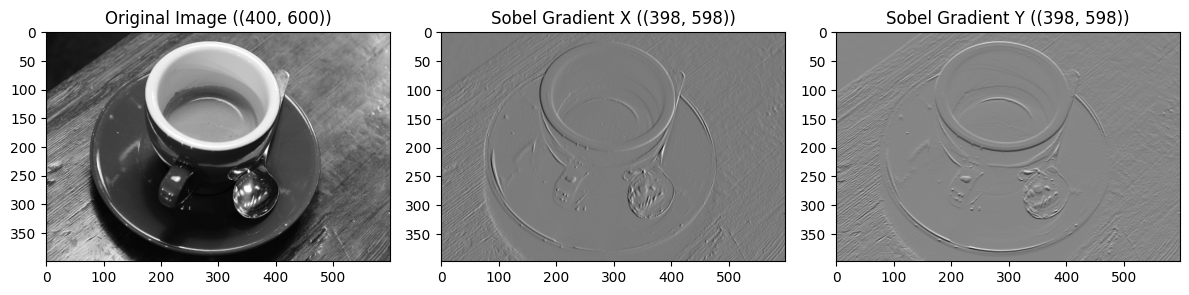

In [ ]:
# prompt: compute the Sobel gradient in X and Y, plot the image and the Sobel components

import skimage.data
import skimage.io
import skimage.color
import skimage.filters

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal
import cv2

img = skimage.io.imread('black_circle.jpg')
img = skimage.data.coffee()

img_gray = skimage.color.rgb2gray(img)

sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

sobel_y = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])

img_sobel_x = scipy.signal.convolve(img_gray, sobel_x, mode='valid').astype(np.float64)
img_sobel_y = scipy.signal.convolve(img_gray, sobel_y, mode='valid').astype(np.float64)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title(f'Original Image ({img_gray.shape})')
plt.imshow(img_gray, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Sobel Gradient X ({img_sobel_x.shape})')
plt.imshow(img_sobel_x, cmap='gray')

plt.subplot(1, 3, 3)
plt.title(f'Sobel Gradient Y ({img_sobel_y.shape})')
plt.imshow(img_sobel_y, cmap='gray')

plt.tight_layout()
plt.show()


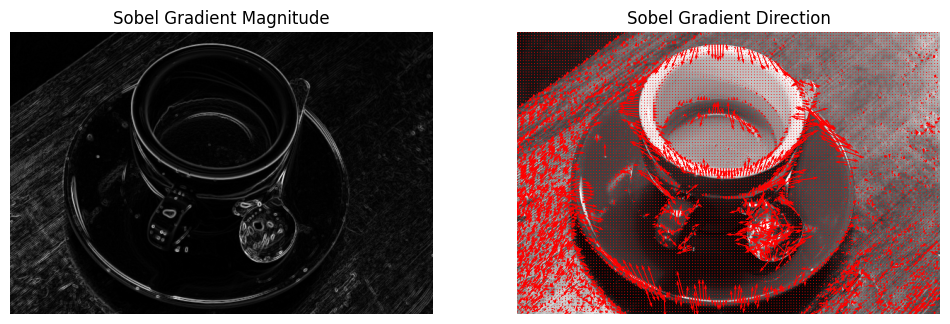

In [ ]:
# prompt: compute the Sobel gradient magnitude and direction. Plot the Sobel direction using quiver plots

import matplotlib.pyplot as plt
import numpy as np
mag_img = np.sqrt(img_sobel_x**2 + img_sobel_y**2).astype(np.float64)
dir_img = np.arctan2(img_sobel_y, img_sobel_x)

# Create a grid of coordinates
step = 4
x = np.arange(0, img_gray.shape[1], step)
y = np.arange(0, img_gray.shape[0], step)
X, Y = np.meshgrid(x, y)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Sobel Gradient Magnitude')
plt.imshow(mag_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Sobel Gradient Direction')
plt.imshow(img_gray, cmap='gray')
plt.quiver(X, Y, img_sobel_x[::step,::step], img_sobel_y[::step,::step], color='red', angles='xy', scale_units='xy')
plt.axis('off')

plt.show()


## Método de Canny

- Esse é um dos métodos mais utilizados para detecção de bordas, devido à sua eficência. O método de Canny realiza os seguintes (visualização na [Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector)):
 - Suavização da imagem através de um filtro Gaussiano (com desvio padrão = $\sigma$)
 - Cálculo de gradientes (normalmente com Sobel)
 - Non-maximum-supression: dada uma janela, conserva somente o pixel de maior valor. Essa etapa geras bordas mais finas.
 - Categorização de bordas com dois valores de limiar ($th_{low}$ a $th_{high}$): dado um valor de intensidade $v$, aplimos a seguinte regra: se $v < th_{low}$ o pixel de borda é eliminado, se $th_{high} < v < th_{low}$, o pixel é consirado borda fraca e passa para a próxima etapa. Se $v > th_{low}$. O pixel é consirado de borda forte e mantido.
 - Histerese: técnica que conecta pixels vizinhos, de forma a facilitar a criação de objetos fechados. Nessa etapa, os pixels fracos e fortes são considerados para possivelmente conectar regiões contínuas.

- Vamos realizar alguns testes no Canny, utilizando estes três principais parâmetros: $\sigma$, $th_{low}$ e $th_{high}$.

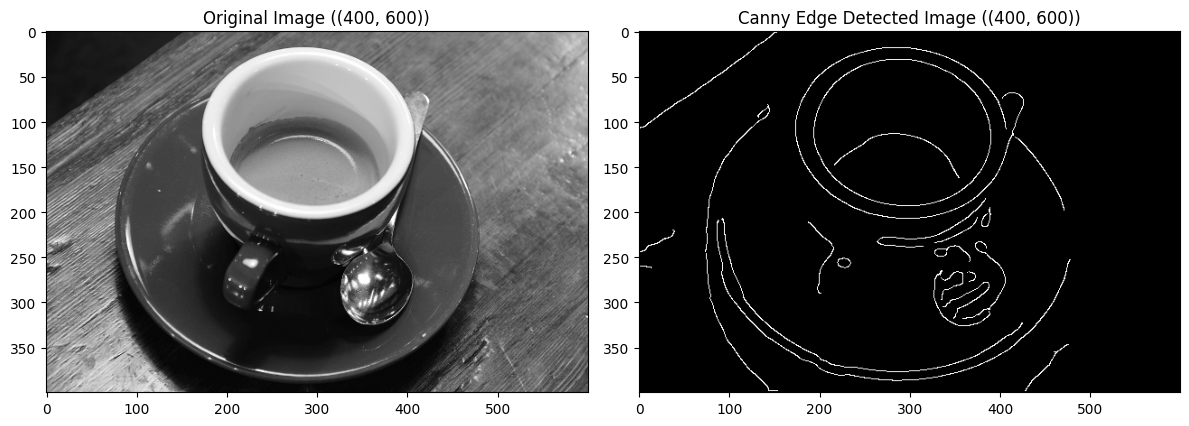

In [ ]:
# @title Parâmetros { run: "auto", form-width: "300px" }
# step by step: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

# prompt: now do the same using Canny edge detector

import skimage.data
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal
import cv2


sigma = 4 #@param
th_low = 0.0  #@param
th_high = 0.2  #@param
img = skimage.data.coffee()
#img = skimage.io.imread('black_circle.jpg')

img_gray = skimage.color.rgb2gray(img)
edges = skimage.feature.canny(img_gray, sigma=sigma, low_threshold=th_low, high_threshold = th_high)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap = 'gray')
plt.title(f'Original Image ({img_gray.shape})')
plt.subplot(1,2,2)
plt.imshow(edges, cmap = 'gray')
plt.title(f'Canny Edge Detected Image ({edges.shape})')

plt.tight_layout()
plt.show()


## Detecção de Saliência

- Detectar regiões salientes na imagem também é bastante importante, pois permite entender em que parte da imagem usuários vão dedicar mais atenção.
- Vamos avaliar o método definido Hou & Zhang (2007), baseado em análise estatísca sobre o domínio espectral (das frequências). Artigo [aqui](https://ieeexplore.ieee.org/document/4270292).


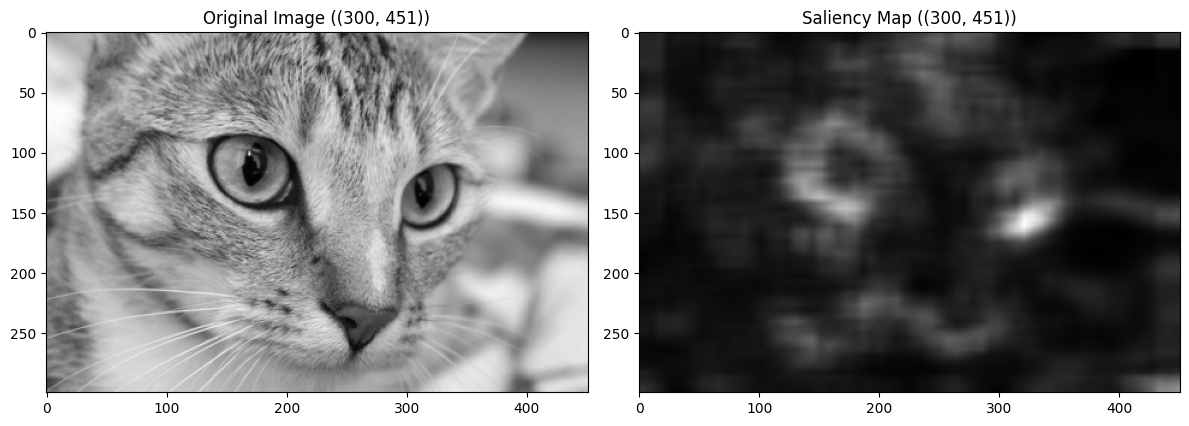

In [ ]:
# prompt: compute the saliency map of img_gray using openCV

import matplotlib.pyplot as plt
import cv2

img = skimage.data.cat()
if img.ndim == 3:
    img_gray = skimage.color.rgb2gray(img)
else:
    img_gray = img

# Create a saliency object
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(img_gray)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap = 'gray')
plt.title(f'Original Image ({img_gray.shape})')
plt.subplot(1,2,2)
plt.imshow(saliencyMap, cmap = 'gray')
plt.title(f'Saliency Map ({saliencyMap.shape})')

plt.tight_layout()
plt.show()


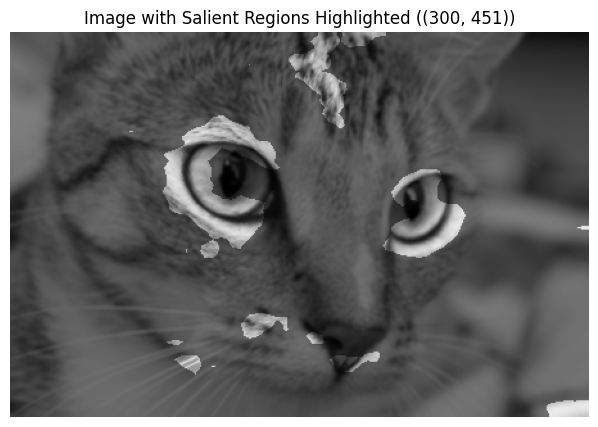

In [ ]:
# prompt: highlight the salient regions on the image

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Create a copy of the original image
img_with_saliency = img_gray.copy()
th = 0.3

# Threshold the saliency map to highlight the most salient regions
_, thresholded_saliency_map = cv2.threshold(saliencyMap, th * np.max(saliencyMap), 255, cv2.THRESH_BINARY)

# Apply the saliency map as a mask to the original image
img_with_saliency[thresholded_saliency_map == 0] = 0

# Display the image with highlighted salient regions
plt.figure(figsize=(12, 5))

dst = np.ones_like(img_gray)


plt.imshow(img_with_saliency, cmap = 'gray')
plt.imshow(cv2.blur(img_gray, ksize=(3,3)), cmap = 'gray', alpha = 0.5)


plt.title(f'Image with Salient Regions Highlighted ({img_with_saliency.shape})')
plt.axis('off')
plt.show()
